Created: 2020.08.13

Modified: 2020.08.20

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

import random
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import gray2rgb

In [3]:
import sys
sys.path.append('functions')

%aimport functions00, functions01
from functions00 import *
from functions01 import *

import functions32 as f32
import functions50 as f50

In [4]:
mk_get_host_info()

**********************************************************************************************************************************
Settings:
	HOST:  mmiv-ml-titan
	PATH_ROOT_DATA:  /data-10tb/shared/skull/train-3d-iso
	PATH_GIT_HUB:  /data-10tb/marek/github_codes/skull-stripping-1/fastai
	PATH_2D: /data-10tb/shared/skull

3D NIFTI image DF paths (_mk_3D):
	IXI_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/ixi_test_mk_3d.csv
	TEST_3D : /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv
	TRAIN_VAL_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/train_val_mk_3d.csv
	NFBS_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/nfbs_test_mk_3d.csv

Error files (pickle):
	ERROR_FILES: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/error_files
***********************************************************


# 2D AXIAL - T1 biascorr

Test set:
1. TEST_3D
1. IXI_TEST_3D
___

#### Some global variables

In [5]:
TEST_SET_NAME = 'IXI_TEST_3D'
SAVE_PTH_301_DATA = PATH_2D / 'pred' / '3.01' / TEST_SET_NAME
SAVE_PTH_301_CSV = PATH_GIT_HUB / '5.0'

### Load df for training; get a few of the train rows

In [6]:
# LOADING TRAIN_VAL CSV FILE, REMOVE VAL PART AND MOST OF THE TRAIN PART
folder_path = PATH_2D /'axial-2d'

# csv file with path to images and masks
DATA_PATH_CSV_2D = 'bias_mask-test-val-axial-2d.csv'

df1 = pd.read_csv(folder_path/DATA_PATH_CSV_2D)
df1 = df1[df1['usage_txt'] == 'train'][:128*3]

# print(df1.shape)
print(df1.shape)
#df_train.head(1)

(384, 6)


In [7]:
# LOAD TEST_3D_CSV
test_name = PATH_2D /'axial-2d' / f'{TEST_SET_NAME}-bias-mask-axial-2d.csv'
df2 = pd.read_csv(test_name, index_col=None)
print(df2.shape)
#df_test.head(2)

(94520, 6)


In [8]:
# CONCATENATE TRAIN ADN TEST TABLES
df_test = pd.concat([df1, df2])
print(df_test.shape)
df_test.tail(2)

(94904, 6)


,root,bias_path,image_full_path,mask_full_path,usage_txt,usage
94518,/data-10tb/shared/skull/axial-2d/,/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_iso_168.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_iso_168.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_brain_mask_iso_nn...,ixi_test_3d,True
94519,/data-10tb/shared/skull/axial-2d/,/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_iso_169.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_iso_169.png,/data-10tb/shared/skull/axial-2d/test/IXI/IXI662-Guys-1120-T1.anat/T1_biascorr_brain_mask_iso_nn...,ixi_test_3d,True


In [9]:
if 'titan' in HOST:
    #df_files_exists(df, ['t1_pth_titan', 'bias_pth_titan', 'mask_nn_pth_titan', 'mask_lin_pth_titan'])
    mk_df_files_exists(df_test, ['image_full_path', 'mask_full_path'])

Looing for NOT EXISTING files in "df.image_full_path"
	All files are OK

Looing for NOT EXISTING files in "df.mask_full_path"
	All files are OK



## Create DataBunch

In [19]:
# item list
il = SegmentationItemList.from_df(df_test, folder_path, cols='bias_path', convert_mode='L')

In [20]:
# split data
sd = il.split_from_df(col='usage')

In [21]:
codes = np.loadtxt(folder_path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [22]:
# label list
ll = sd.label_from_df(cols='mask_full_path', classes=codes)

In [23]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=128
size = 128

In [24]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [25]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [26]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

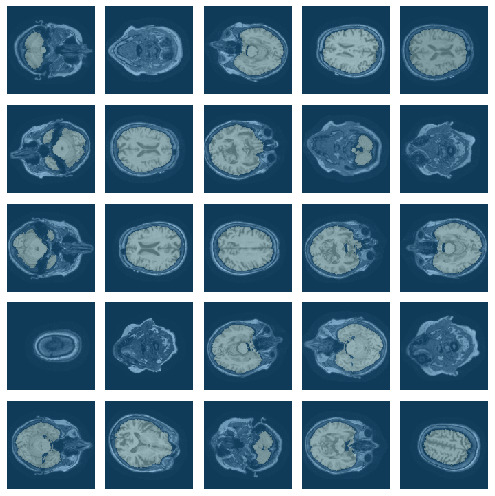

In [27]:
data.show_batch(5, figsize=(7,7))

In [28]:
# load a model
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)
learn.load('3.01_02_train-axial_bias_uf_foc-20_lr-1e3_sp-all');

### Predictions

In [29]:
%%time
pred = 0
if pred:
    #predykcje 
    pred = learn.get_preds()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


### Create an empty arrrays for results (fsl_128, pred_128, x_128)

In [30]:
%%time
create = 0
if create:
    # tworzymy macierze z obrazami
    n = len(learn.data.valid_dl.dataset.items)
    fsl_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    pred_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    x_128 = np.zeros((n, 128, 128), dtype=np.float32)

CPU times: user 53 µs, sys: 4 µs, total: 57 µs
Wall time: 104 µs


### Fill in arrays with 2D images

In [31]:
%%time
# Fill in fsl_128 and pred_128 with label and prediction
fillin = 0
if fillin:
    k = 0
    for k in range(n):
        x,y = learn.data.valid_ds[k]  
        p,_,_ = learn.predict(x)

        fsl_128[k,:,:] = np.squeeze(to_np(y))
        x_128[k,:,:] = np.squeeze(to_np(x))
        pred_128[k,:,:] = np.squeeze(to_np(p))  
        print(f'{k:06}/{n}', end='\r')
        k += 1

CPU times: user 17h 59min 22s, sys: 51min 4s, total: 18h 50min 26s
Wall time: 36min 51s


In [23]:
# nazwy plikow
#learn.data.valid_dl.dataset.items[0]

### Save predictinos to a disc

In [34]:
%%time
save1 = 0
if save1:  
    # create a df with all 2d filenames
    full_names = list(learn.data.valid_dl.items)
    mask_full_path=list(df2.mask_full_path)
    # save matrix with predictions to npz file
    # save uncompressed 
    save_name = f'3.01_{TEST_SET_NAME}_uncompressed_results'
    save_pth = SAVE_PTH_301_DATA / save_name
    np.savez(save_pth, full_names=full_names, fsl_128=fsl_128, pred_128=pred_128, x_128=x_128, mask_full_path=mask_full_path)
    print(save_pth)

/data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/3.01_IXI_TEST_3D_uncompressed_results
CPU times: user 10.6 s, sys: 3.6 s, total: 14.2 s
Wall time: 27.7 s


In [35]:
%%time
save2 = 0
if save2:
    # create a df with all 2d filenames
    full_names = list(learn.data.valid_dl.items)
    mask_full_path=list(df2.mask_full_path)
    # save compressed 
    save_name = f'3.01_{TEST_SET_NAME}_compressed_results'
    save_pth = SAVE_PTH_301_DATA / save_name
    np.savez_compressed(save_pth, full_names=full_names, fsl_128=fsl_128, pred_128=pred_128, x_128=x_128, mask_full_path=mask_full_path)
    print(save_pth)

/data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/3.01_IXI_TEST_3D_compressed_results
CPU times: user 2min 28s, sys: 3.09 s, total: 2min 31s
Wall time: 2min 33s


___